In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# file = drive.CreateFile({'id': '1aLon9sOQd49HNV0-Deo2XMwf-49XlL5P'})
# file.GetContentFile('data.zip')
# file = drive.CreateFile({'id': '1STxR_DQE0JCDpIE_9JzkgTTx4j-ga7YG'})
# file.GetContentFile('annotations.zip')
file = drive.CreateFile({'id': '1L65sqe976Ty4bl47wn8Wzpk-BmEVLUAR'})
file.GetContentFile('data.zip')

In [0]:
!unzip data.zip >/dev/null
# !unzip annotations.zip >/dev/null
# !rm ./Data/56478665_421907071715102_3762114008077828096_n.jpg # this image has no object, so removing it (no xml exists for it)
# !rm ./Data/55912462_267292044150469_7933255829271085056_n.jpg # this image has no object, so removing it (no xml exists for it)

In [0]:
import cv2
import glob
import xml.etree.ElementTree as ET
import os
import numpy as np
from matplotlib import pyplot as plt
import imutils
from PIL import Image

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import pandas as pd
import random
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
img_shape = 224

In [0]:
def scale(img, imgNewWidth, imgNewHeight, imgX1=None, imgX2=None, imgY1=None, imgY2=None, interpolation=cv2.INTER_LINEAR):
    
    '''Args: Image, new image width, new image height, 
                 top left point x-coordinates, bottom right point x-coordinates,
                 top left point y-coordinates, bottom right point y-coordinates'''

    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape
    
    imgTemp = cv2.resize(imgTemp, (imgNewWidth, imgNewHeight), interpolation=interpolation)
    
    if imgX1!=None:
        fY = float(imgNewHeight)/float(imgHeight)
        fX = float(imgNewWidth)/float(imgWidth)

        imgX1 = max(0, int(imgX1*fX))
        imgX2 = min(int(imgX2*fX), imgNewWidth)
        imgY1 = max(0, int(imgY1*fY))
        imgY2 = min(int(imgY2*fY), imgNewHeight)


        return imgTemp, imgX1, imgX2, imgY1, imgY2
    else:
        return imgTemp

In [0]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [0]:
def ip(img):
  img = cv2.GaussianBlur(img, (69, 69), 500)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  # hsv = cv2.threshold(hsv,127,255,cv2.THRESH_BINARY_INV)

  lower = np.array([1,0,0])
  upper = np.array([255,255,100])
  
  mask = cv2.inRange(hsv, lower, upper)
  
  return mask

In [0]:
nobot_images = []
bot_images = []
nobot_labels = []
bot_labels = [] # labels are [xmin, xmax, ymin, ymax]
file_list = list(glob.glob('./Images/*/*'))
for file in file_list:
  img = cv2.imread(file)
  mask = np.expand_dims(ip(img),axis=2)
  img = np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis=2)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#   tree = ET.parse(os.path.join(annot_dir, file.split('/')[-1])[:-3] + 'xml')
  tree = ET.parse(os.path.join('Labels', '/'.join(file.split('/')[-2:])[:-3] + 'xml'))
  root = tree.getroot()
  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)
  box = (root.find('object')).find('bndbox')
  xmin = int(box[0].text)
  ymin = int(box[1].text)
  xmax = int(box[2].text)
  ymax = int(box[3].text)
  
#   if(width > height):
#     img = imutils.rotate_bound(img, 90)
#     xmax, ymin, xmin, ymax = height-ymin, xmin, height-ymax, xmax

  img = preprocess_input(img)
  mask = np.expand_dims(scale(mask, img_shape, img_shape), axis=2)
  img, xmin, xmax, ymin, ymax = scale(img, img_shape, img_shape, xmin, xmax, ymin, ymax)
  img = np.concatenate([img, mask], axis=2)
  
  if (file.split('/')[-2] == 'Cropped Bottles'):
    bot_images.append(img)
    bot_labels.append([xmin, xmax, ymin, ymax])
  else:
    nobot_images.append(img)
    nobot_labels.append([xmin, xmax, ymin, ymax])
    
nobot_images = np.array(nobot_images)
bot_images = np.array(bot_images)
nobot_labels = np.array(nobot_labels)
bot_labels = np.array(bot_labels) 

# images = np.stack(3*[images], axis=3)
# images = (images-np.mean(images, axis=0))/(np.max(images)-np.min(images))

In [0]:
print(nobot_images.shape, nobot_labels.shape, bot_images.shape, bot_images.shape)

(563, 224, 224, 4) (563, 4) (253, 224, 224, 4) (253, 224, 224, 4)


In [0]:
def horizontalFlip(img, imgX1=None, imgX2=None, imgY1=None, imgY2=None):
    '''Args: Image, top left point x-coordinates, bottom right point x-coordinates,
                 top left point y-coordinates, bottom right point y-coordinates 
                 original_shape = (height, width)'''
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = img.shape
    imgTemp = cv2.flip(imgTemp, 1)
    
    if imgX1!=None:
        imgX1, imgX2 = imgWidth - imgX2, imgWidth - imgX1 
        imgY1 = imgY1
        imgY2 = imgY2
        
        return imgTemp, imgX1, imgX2, imgY1, imgY2
    else:
        return imgTemp 

def verticalFlip(img, imgX1=None, imgX2=None, imgY1=None, imgY2=None):
    
    '''Args: Image, top left point x-coordinates, bottom right point x-coordinates,
                 top left point y-coordinates, bottom right point y-coordinates
    '''
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = img.shape
    imgTemp = cv2.flip(imgTemp, 0)
    
    if imgX1!=None:
        imgX1 = imgX1
        imgX2 = imgX2 
        imgY1, imgY2 = imgHeight - imgY2, imgHeight - imgY1

        return imgTemp, imgX1, imgX2, imgY1, imgY2
    else:
        return imgTemp


In [0]:
class DataGenerator(Sequence):

    def __init__(self, images, labels, batch_size, val=False, p=0.5, scale_range=(0.8,1.2)):
      
        super(DataGenerator, self).__init__()
        
        images, labels = shuffle_in_unison(images, labels)
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.index = 0
        self.p = p
        self.scale_range = scale_range
        self.index=0

    def __len__(self):
        return int(len(self.images)/self.batch_size)+1
    
#     def on_epoch_end():
#         self.images, self.labels = shuffle_in_unison(self.images, self.labels)

    def __getitem__(self, idx):
        
        batch_images = []
        batch_coords = []
        for i in range(self.batch_size):
          image = (self.images[((idx*self.batch_size)+i) % len(self.images)]).copy()
          label = (self.labels[((idx*self.batch_size)+i) % len(self.images)]).copy()
          
          if random.random() > self.p:
            image, label[0], label[1], label[2], label[3] = horizontalFlip(image, imgX1=label[0], imgX2=label[1], imgY1=label[2], imgY2=label[3])
          if random.random() > self.p:
            image, label[0], label[1], label[2], label[3] = verticalFlip(image, imgX1=label[0], imgX2=label[1], imgY1=label[2], imgY2=label[3])

          batch_images.append(image)
          batch_coords.append(label)
        
        # batch_images [batch_size, img_shape, img_shape, 3]
        # batch_coords [batch_size, 4] - [x,x+w,y,y+h] - x,y is top left corner
        
        return np.array(batch_images), np.array(batch_coords)

In [0]:
val_split = 0.1

In [0]:
bot_images, bot_labels = shuffle_in_unison(bot_images, bot_labels)
nobot_images, nobot_labels = shuffle_in_unison(nobot_images, nobot_labels)

bot_train_examples = int(bot_images.shape[0] * (1-val_split))
nobot_train_examples = int(nobot_images.shape[0] * (1-val_split))

train_images = np.concatenate([bot_images[:bot_train_examples], nobot_images[:nobot_train_examples]], axis=0)
val_images = np.concatenate([bot_images[bot_train_examples:], nobot_images[nobot_train_examples:]], axis=0)

train_labels = np.concatenate([bot_labels[:bot_train_examples], nobot_labels[:nobot_train_examples]], axis=0)
val_labels = np.concatenate([bot_labels[bot_train_examples:], nobot_labels[nobot_train_examples:]], axis=0)

# train_labels_cat = to_categorical(train_labels[:,-1], num_classes=2, dtype='uint8')
# val_labels_cat = to_categorical(val_labels[:,-1], num_classes=2, dtype='uint8')

# train_labels_cat = train_labels[:,-1]
# val_labels_cat = val_labels[:,-1]

# train_labels = train_labels[:,:-1]
# val_labels = val_labels[:,:-1]

print(bot_train_examples, ' training examples of bottle')
print(bot_images.shape[0] - bot_train_examples, ' validation examples of bottle')

print(nobot_train_examples, ' training examples of non-bottle')
print(nobot_images.shape[0] - nobot_train_examples, ' validation examples of non-bottle')

print('total ', train_images.shape[0], ' training images')
print('total ', val_images.shape[0], ' val images')

train_datagen = DataGenerator(train_images, train_labels, 4)
val_datagen = DataGenerator(val_images, val_labels, 4)

227  training examples of bottle
26  validation examples of bottle
506  training examples of non-bottle
57  validation examples of non-bottle
total  733  training images
total  83  val images


In [0]:
# model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
# model.summary()

In [0]:
def create_model(img_size=224, trainable=False):

#     model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False)
    
#     for layer in model.layers:
#         layer.trainable = trainable
        
#     for layer in model.layers:
#       if layer.name == 'block_3_project_BN':
#         x = layer.output
#         break
    
    regulariz = regularizers.l2(1)
#     regulariz = None
        
    inp = Input(shape=(224, 224, 4))
    x = Conv2D(28, kernel_size=3, name="new_conv", activation='relu', kernel_regularizer=regulariz)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(48, kernel_size=3, name="new_conv1", activation='relu', kernel_regularizer=regulariz)(x)
#     x = BatchNormalization()(x)
    x = Conv2D(56, kernel_size=3, name="new_conv3", activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regulariz)(x)
    pred = Dense(4, name="pred")(x)

    return Model(inputs=inp, outputs=pred)

In [0]:
model = create_model(img_size=img_shape)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 4)       0         
_________________________________________________________________
new_conv (Conv2D)            (None, 222, 222, 28)      1036      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 222, 222, 28)      112       
_________________________________________________________________
new_conv1 (Conv2D)           (None, 220, 220, 48)      12144     
_________________________________________________________________
new_conv3 (Conv2D)           (None, 218, 218, 56)      24248     
_________________________________________________________________
flatten (Flatten)    

In [0]:
def iou_metric(y_true, y_pred):
  
    '''label format - [xmin, xmax, ymin, ymax]'''
    
#     print(y_pred.shape)
    
    gt = y_true
    pred = y_pred

    diff_width = K.minimum(gt[:,1], pred[:,1]) - K.maximum(gt[:,0], pred[:,0])
    diff_height = K.minimum(gt[:,3], pred[:,3]) - K.maximum(gt[:,2], pred[:,2])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = (gt[:,1]-gt[:,0]) * (gt[:,3]-gt[:,2])
    area_pred = (pred[:,1]-pred[:,0]) * (pred[:,3]-pred[:,2])
    union = K.maximum(area_gt + area_pred - intersection, 0)
    
    iou = K.round(intersection / (union + epsilon()))
    
    return iou

In [0]:
lr = 1e-4
epochs=500

In [0]:
# loss_weights = {"pred" : 1, "class_" : 100}

model.compile(loss="mean_squared_error", optimizer= optimizers.Adam(lr=lr), metrics=[iou_metric])

# print(model.metrics_name)

checkpoint = ModelCheckpoint("model-{val_iou_metric:.2f}.h5", monitor="val_iou_metric", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=5)
# stop = EarlyStopping(monitor="iou_metric", patience=5, mode="max")
# reduce_lr = ReduceLROnPlateau(monitor="iou_metric", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

model.fit_generator(generator=train_datagen, validation_data=val_datagen, epochs=epochs, callbacks=[checkpoint], shuffle=True, verbose=1)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
184/184 [==============================] - 21s 117ms/step - loss: 1202.4140 - iou_metric: 0.1562 - val_loss: 630.6521 - val_iou_metric: 0.1310
Epoch 2/500
184/184 [==============================] - 18s 98ms/step - loss: 574.2126 - iou_metric: 0.3315 - val_loss: 536.8448 - val_iou_metric: 0.2738
Epoch 3/500
184/184 [==============================] - 18s 98ms/step - loss: 474.2299 - iou_metric: 0.4171 - val_loss: 485.5816 - val_iou_metric: 0.3810
Epoch 4/500
184/184 [==============================] - 18s 97ms/step - loss: 403.4482 - iou_metric: 0.4946 - val_loss: 488.9841 - val_iou_metric: 0.4048
Epoch 5/500
21/21 [==============================] - 0s 16ms/step - loss: 408.1707 - iou_metric: 0.5119

Epoch 00005: val_iou_metric improved from -inf to 0.51190, saving model to model-0.51.h5
184/184 [==============================] - 19s 104ms/step - loss: 400.4990 - iou_metric: 0.5136 

KeyboardInterrupt: ignored

In [0]:
# file = file_list[1]
# img = cv2.imread(file)
# mask = ip(img) # For ip - isn't appended yet
# img = np.stack([img[:,:,2], img[:,:,1], img[:,:,0]], axis=2)
# #   img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #   tree = ET.parse(os.path.join(annot_dir, file.split('/')[-1])[:-3] + 'xml')
# tree = ET.parse(os.path.join('Labels', '/'.join(file.split('/')[-2:])[:-3] + 'xml'))
# root = tree.getroot()
# size = root.find('size')
# width = int(size.find('width').text)
# height = int(size.find('height').text)
# box = (root.find('object')).find('bndbox')
# xmin = int(box[0].text)
# ymin = int(box[1].text)
# xmax = int(box[2].text)
# ymax = int(box[3].text)
# print(([xmin, xmax, ymin, ymax]))
# img = cv2.rectangle(img,(xmin, ymin),(xmax, ymax), (0,255,0) ,3)
# plt.imshow(img)

In [0]:
file = drive.CreateFile({'title': 'BBmodel-0.80.h5'})
file.SetContentFile('model-0.80.h5')
file.Upload()

In [0]:
model.load_weights('model-0.80.h5')

In [0]:
batch_images, batch_coords = val_datagen.__getitem__(1)
i=0

In [0]:
pred = model.predict_on_batch(batch_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
[ 78.12192  137.43825  106.196686 166.93098 ]


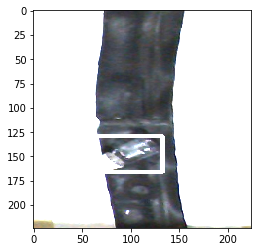

In [0]:
i=(i+1)%4
print(i)
print(pred[i])
img = batch_images[i][:,:,:-1].copy()+1
max_ = int(np.max(img))
img = cv2.rectangle(img,(batch_coords[i][0], batch_coords[i][2]),(batch_coords[i][1],batch_coords[i][3]),(max_, max_, max_),3)
# img = cv2.rectangle(img,(batch_coords[i][0], batch_coords[i][2]),(batch_coords[i][1],batch_coords[i][3]), (0,255,0) ,3)
plt.imshow(img)

In [0]:
# img_new, imgX1, imgX2, imgY1, imgY2 = scale(img, 224, 224, imgX1=xmin, imgX2=xmax, imgY1=ymin, imgY2=ymax)
# img_new = cv2.rectangle(img_new, (imgX1, imgY1),(imgX2, imgY2), (0,255,0) ,1)
# plt.imshow(img_new)

In [0]:
# def scale_pad(img, zoom_range=(0.8,1.2), imgX1=None, imgX2=None, imgY1=None, imgY2=None, interpolation=cv2.INTER_LINEAR):
    
#     '''Args: Image, new image width, new image height, 
#                  top left point x-coordinates, bottom right point x-coordinates,
#                  top left point y-coordinates, bottom right point y-coordinates, 
#                  interpolation    '''

#     imgTemp = img.copy()
#     imgHeight, imgWidth, _ = imgTemp.shape
#     zoom = random.uniform(zoom_range[0], zoom_range[1])
#     imgNewWidth = imgWidth*zoom
#     imgNewHeight = imgHeight*zoom
#     imgTemp = cv2.resize(imgTemp, (imgNewWidth, imgNewHeight), interpolation=interpolation)
#     diffWidth = (imgNewWidth - imgWidth)
#     diffHeight = (imgNewHeight - imgHeight)
#     width_off = int(diffWidth/2)
#     height_off = int(diffHeight/2)
#     if(width_off>0):
#       imgTemp = imgTemp[height_off:height_off+imgHeight, width_off:width_off+imgWidth]
#     else:
#       imgTemp = cv2.copyMakeBorder(imgTemp, int(height_off/2), imgHeight-imgNewHeight-int(height_off/2), int(width_off/2), 
#                                    imgWidth-imgNewWidth-int(width_off/2), BORDER_REPLICATE )

#     if imgX1!=None:
#         fY = float(imgNewHeight)/float(imgHeight)
#         fX = float(imgNewWidth)/float(imgWidth)

#         imgX1 = max(0, int(imgX1*fX))
#         imgX2 = min(int(imgX2*fX), imgNewWidth)
#         imgY1 = max(0, int(imgY1*fY))
#         imgY2 = min(int(imgY2*fY), imgNewHeight)
        
#         imgX1 -= width_off
#         imgX2 -= width_off
#         imgY1 -= height_off
#         imgY2 -= heght_off

#         return imgTemp, imgX1, imgX2, imgY1, imgY2
#     else:
#         return imgTemp

In [0]:
# class repeat_channel(image_gen):
#   def __init__(self, image_gen):
#     super(repeat_channel, self).__init__()
#     self.gen = image_gen
    
#   def __len__(self):
#     return 141
  
#   def __getitem__(self, idx):
#     img, y = self.gen.next()
#     return (np.concatenate([img,img,img], axis=3), y)

In [0]:
# from google.colab import files
# uploaded = files.upload()
# for k, v in uploaded.items():
#   open(k, 'wb').write(v)
# list(uploaded.keys())

In [0]:
# batch_images, batch_coords = train_datagen.__getitem__(0)
# i=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
[ 73 146  69 106]


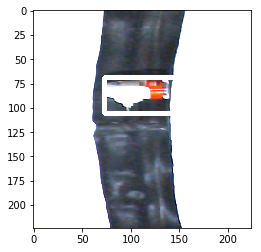

In [0]:
# i=(i+1)%4
# print(i)
# print(batch_coords[i])
# img = batch_images[i].copy()+1
# max_ = int(np.max(img))
# img = cv2.rectangle(img,(batch_coords[i][0], batch_coords[i][2]),(batch_coords[i][1],batch_coords[i][3]),(max_, max_, max_),3)
# # img = cv2.rectangle(img,(batch_coords[i][0], batch_coords[i][2]),(batch_coords[i][1],batch_coords[i][3]), (0,255,0) ,3)
# plt.imshow(img)

In [0]:
# datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.7,1.3), zoom_range=0.4, 
#                    fill_mode='reflect', horizontal_flip=True, vertical_flip=True, rescale=1/255, validation_split=0.1)